# Bayesian mediation analysis in PyMC3

**WARNING:** This is not finished. I believe this is correct for standardised data, but I have not checked this!

**Author:** [Ben Vincent](https://github.com/drbenvincent)

This notebook outlines how to do a basic [mediation analysis](https://en.wikipedia.org/wiki/Mediation_(statistics)) in PyMC3. The implimentation is based on the paper Bayesian Mediation Analysis by Yuan & MacKinnon (2009). In brief, we want to know if a relationship $x \rightarrow y$ is mediated (wholey or partially) by a mediator $m$. 

The basic approach by Yuan & MacKinnon (2009) is to conduct inference on the parameters of a mediation model:

![Mediation model diagram](figs/mediation_model.png)

$$
m = \text{Normal}(m_{\text{intercept}} + \alpha \cdot x, \sigma_m) \\
y = \text{Normal}(y_{\text{intercept}} + \beta \cdot m + \tau' \cdot x, \sigma_y)
$$

So we basically calculate $P(\alpha, \beta, \tau', m_{\text{intercept}}, y_{\text{intercept}}, \sigma_m, \sigma_y| x, m, y)$.

This requires priors for $\alpha, \beta, \tau', m_{\text{intercept}}, y_{\text{intercept}}, \sigma_m, \sigma_y$. The approach taken by Yuan & MacKinnon (2009) is to use very broad (i.e. uninformative priors), but we can obviously try to do better than this if we have domain knowledge.

Note that this model defines a "mediation effect" which is $\theta = \alpha \cdot \beta$. We also have a "direct effect" which is $\tau'$. Depending on whether $\theta = 0$ and/or $\tau'=0$, we can draw various conclusions.

Also, the approach of Yuan & MacKinnon (2009) is very much a 'parameter estimation' approach. More of a hypothesis testing approach, with shift of focus on to Bayes Factors is provided by Nuijten et al (2014).

## Setup
Optional: If you want to use autoformatter, then 

    pip install nb-black

In [ ]:
%load_ext lab_black

In [1]:
import numpy as np
import pandas as pd

# plotting
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 14})

import pymc3 as pm
import arviz as az

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.8


## Define options

In [3]:
SEED = 123

n_samples = 2_000

sample_options = {
    "tune": 2_000,
    "draws": n_samples,
    "chains": 2,
    "cores": 2,
    "nuts_kwargs": {"target_accept": 0.95},
    "random_seed": SEED,
}

np.random.seed(SEED)

## Create synthetic dataset

In [2]:
N = 50

# define parameters (only used in the context of simulated data)
α, β, τprime = 0.5, 0.6, 0.3

params = {"α": α, "β": β, "τprime": τprime}

# calculate the true mediation effect
θ = α * β

In [10]:
def make_data():
    x = np.random.randn(N)
    m = α * x + np.random.randn(N)
    y = τprime * x + β * m + np.random.randn(N)
    return x, m, y

x, m, y = make_data()

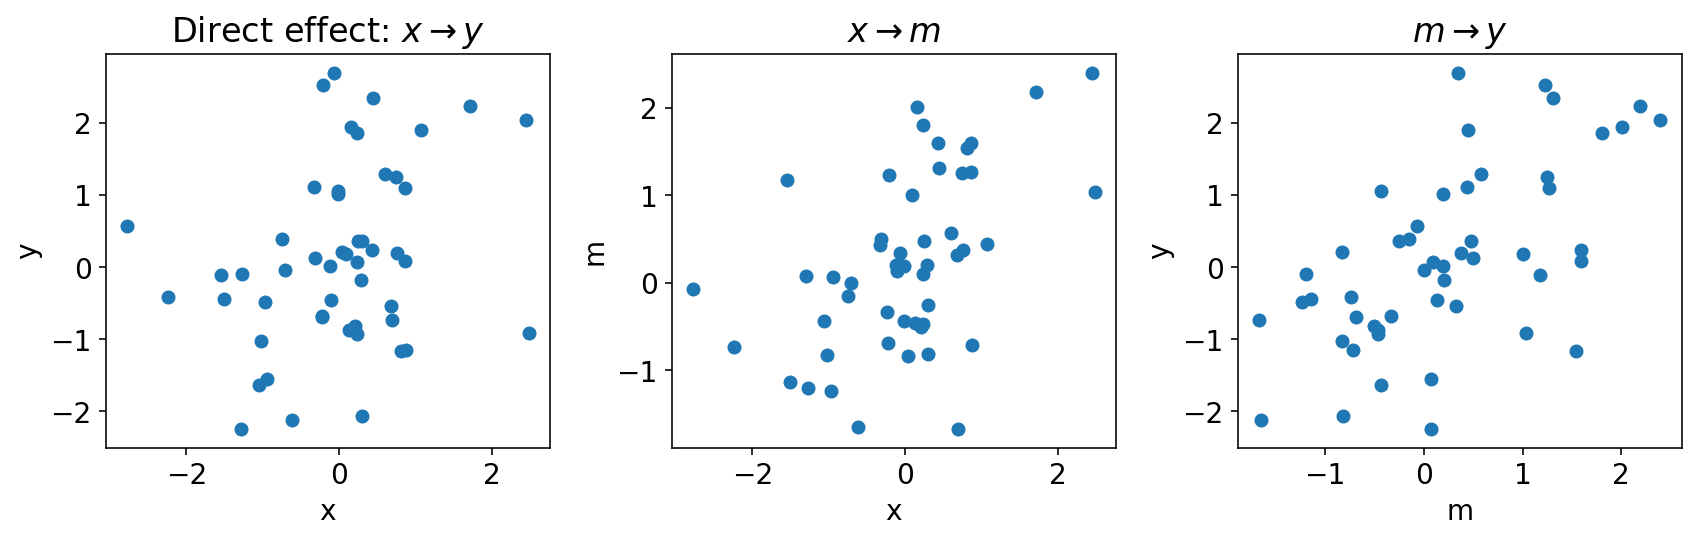

In [20]:
def plot_data(x, m, y):

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    ax[0].scatter(x, y)
    ax[0].set(xlabel="x", ylabel="y", title=r"Direct effect: $x \rightarrow y$")

    ax[1].scatter(x, m)
    ax[1].set(xlabel="x", ylabel="m", title=r"$x \rightarrow m$")

    ax[2].scatter(m, y)
    ax[2].set(xlabel="m", ylabel="y", title=r"$m \rightarrow y$")

    fig.tight_layout()

    return ax

ax = plot_data(x, m, y)

## Make model

In [12]:
def bayesian_mediation(x, m, y):
    """Conduct simple Bayesian mediation analysis.
    This is an implimentation of Yuan & MacKinnon (2009) in PyMC3.
    Returns the model and the trace."""

    print("WARNING: Priors must be updated to suit your specific data context")

    with pm.Model() as model:
        m_intercept = pm.Normal("m_intercept", mu=0, sd=10)
        y_intercept = pm.Normal("y_intercept", mu=0, sd=10)
        α = pm.Normal("α", mu=0, sd=10)
        β = pm.Normal("β", mu=0, sd=10)
        τprime = pm.Normal("τprime", mu=0, sd=10)

        σm = pm.HalfCauchy("σm", 1)
        σy = pm.HalfCauchy("σy", 1)

        m = pm.Normal("m", mu=m_intercept + α * x, sd=σm, observed=m)
        y = pm.Normal("y", mu=y_intercept + β * m + τprime * x, sd=σm, observed=y)

        # calculate the "mediated effect"
        θ = pm.Deterministic("θ", α * β)

    with model:
        trace = pm.sample(**sample_options)

    return model, trace

In [13]:
model, trace = bayesian_mediation(x, m, y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σy, σm, τprime, β, α, y_intercept, m_intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:04<00:00, 1725.92draws/s]


## Due diligence: plot the traces

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd478065410>,
      dtype=object)

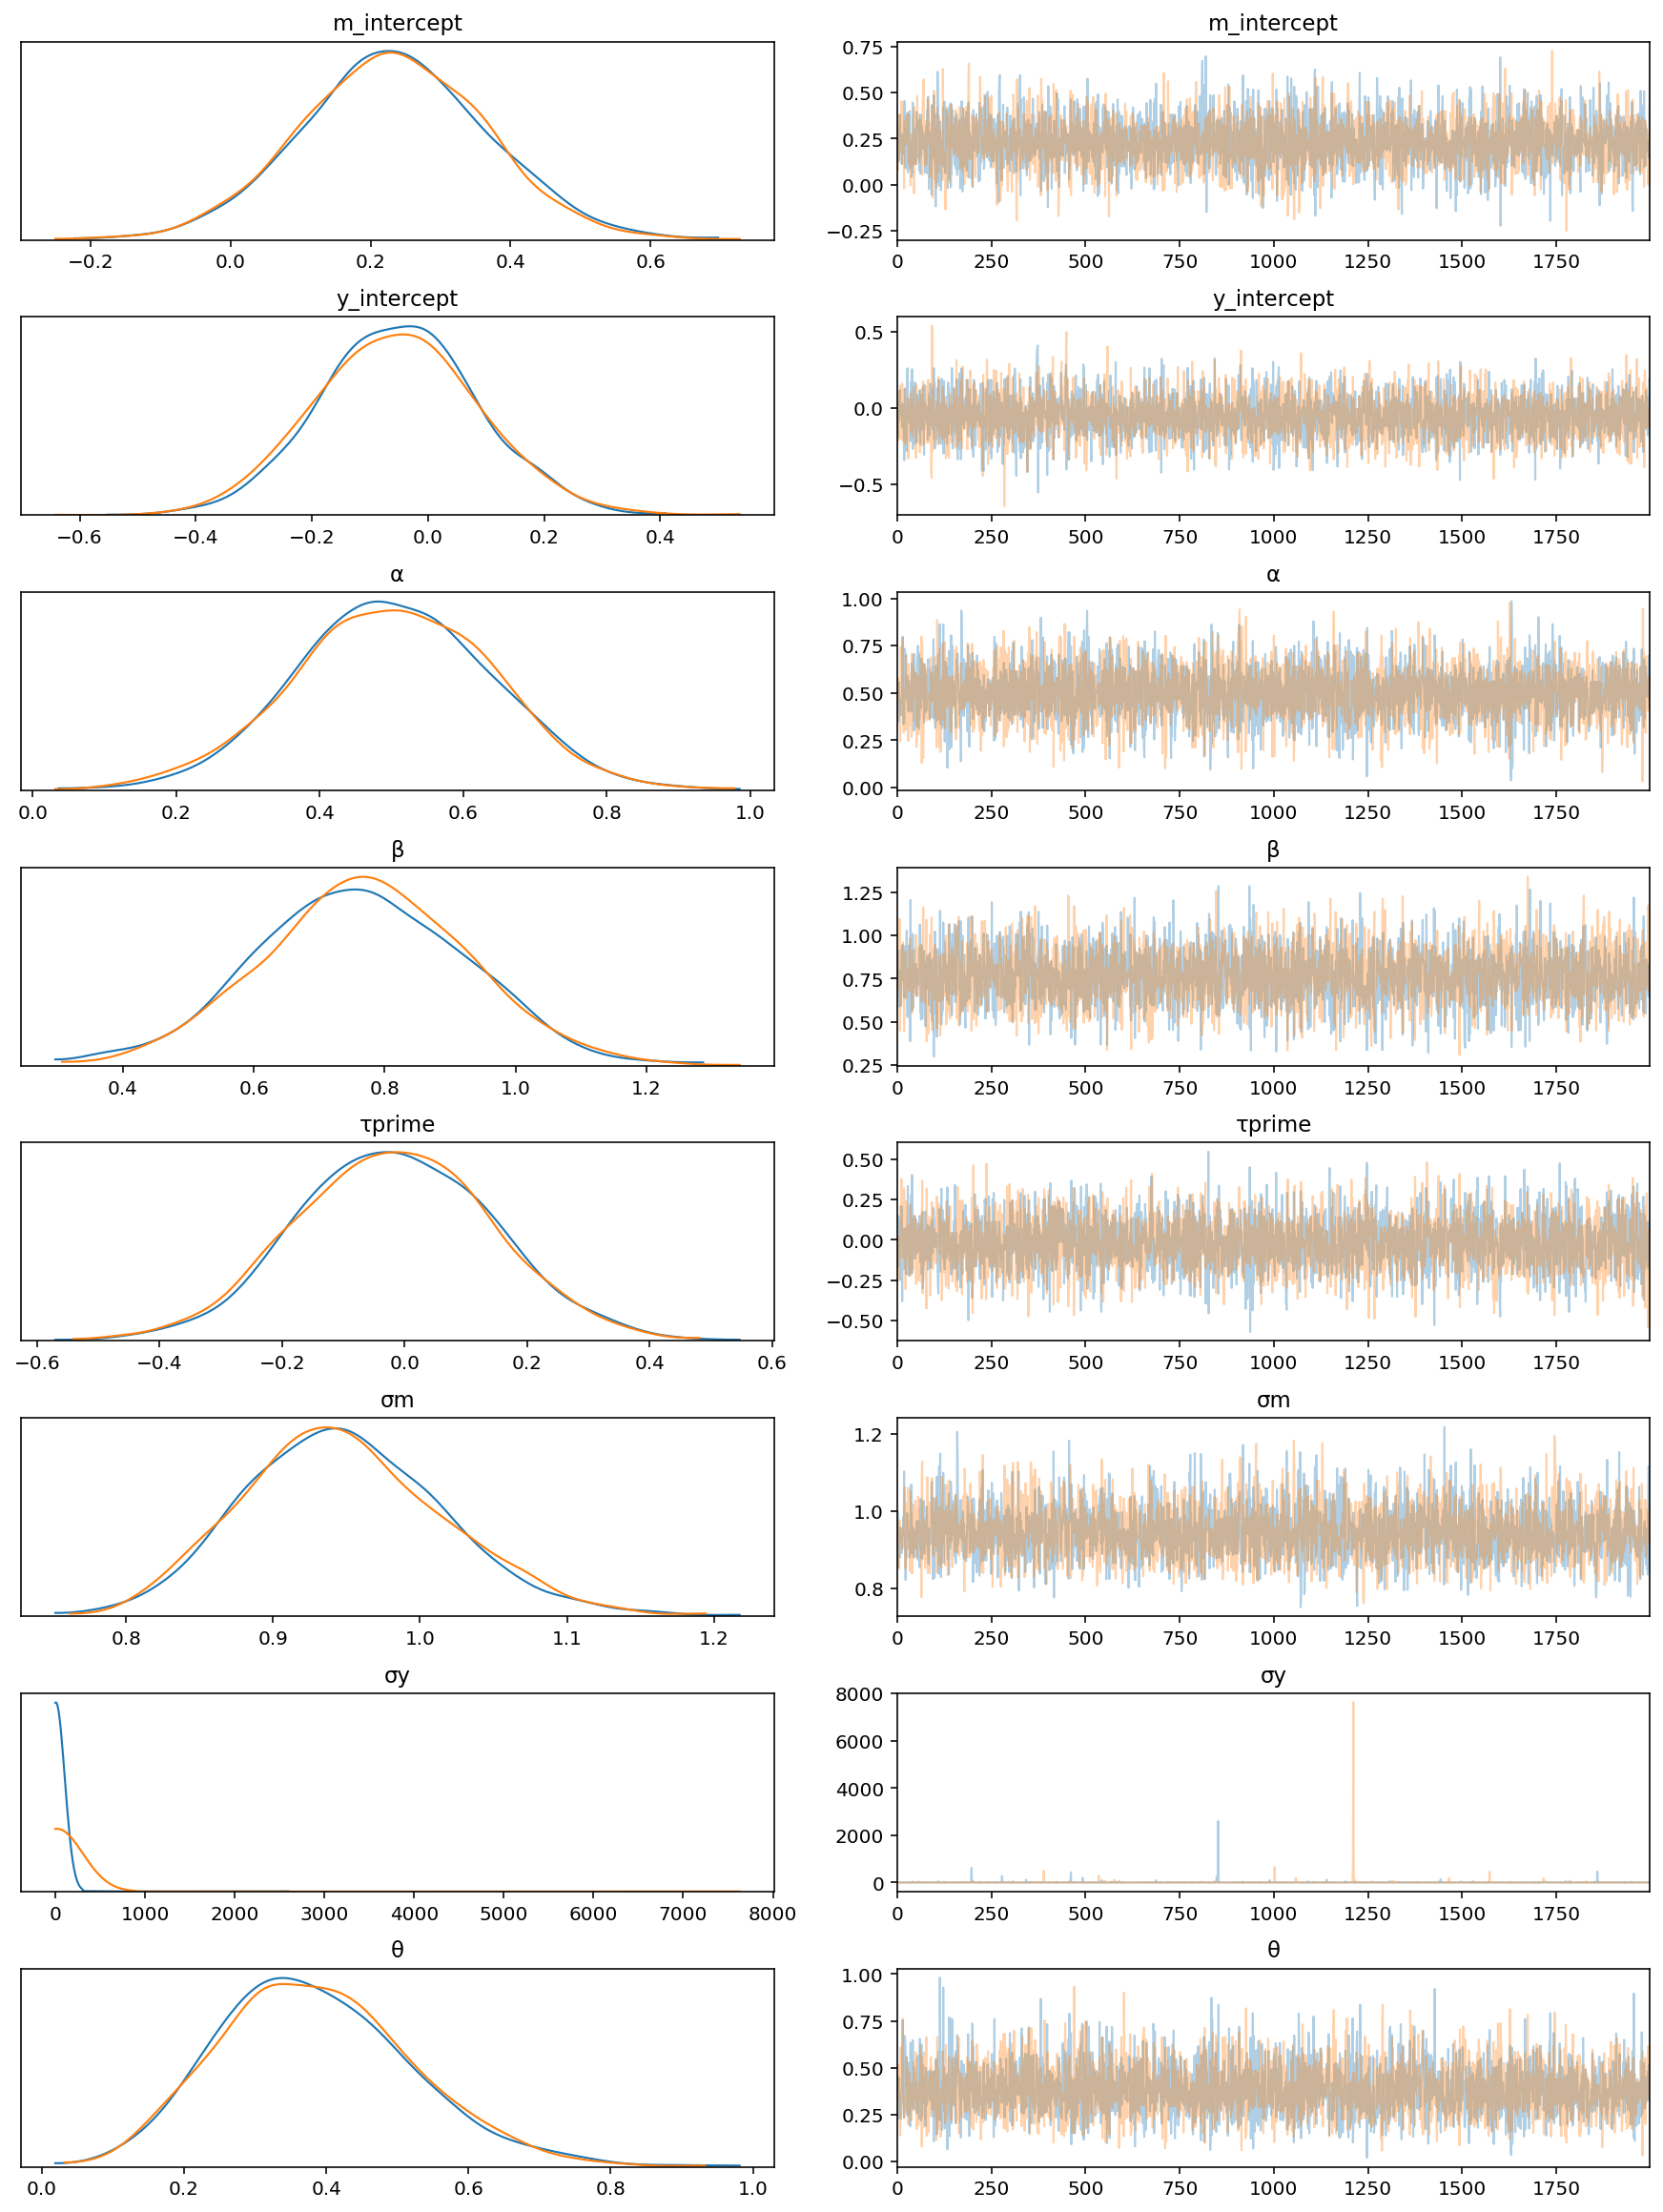

In [14]:
az.plot_trace(trace)

Check the trace if you like, using:

    pm.traceplot(trace)

## Is there a "mediation effect"?
The mediation effect is given by $\theta = \alpha \cdot \beta$. The posterior will tell us our beliefs about the mediation effect given the data. In particular, is it credibly non-zero?

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd4ffa00690>],
      dtype=object)

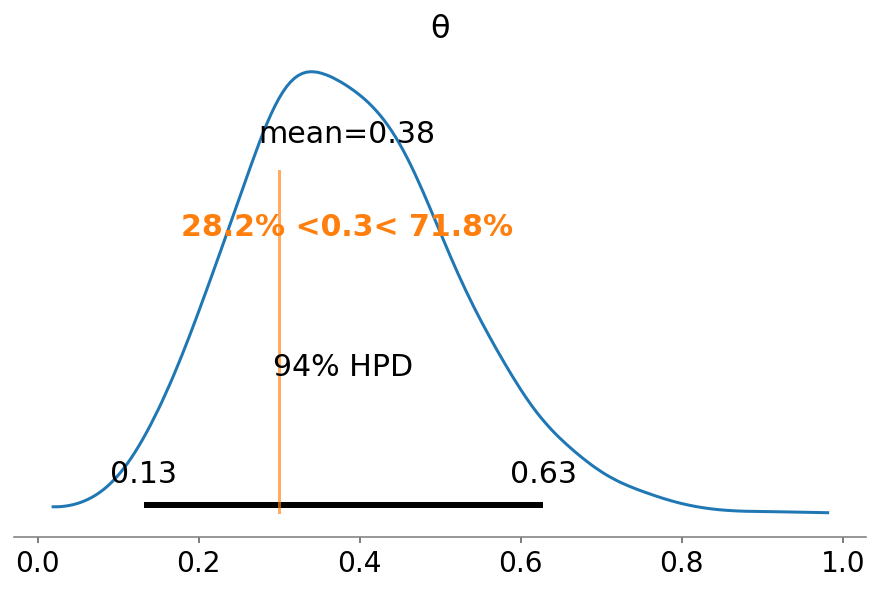

In [15]:
az.plot_posterior(trace, var_names="θ", ref_val=θ)

## Is there a direct effect $\tau'$ between $x$ and $y$?
The direct effect between $x$ and $y$ is given by $\tau'$. The posterior will tell us our beliefs about it given the data. In particular, is it credibly non-zero?

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd4b84203d0>],
      dtype=object)

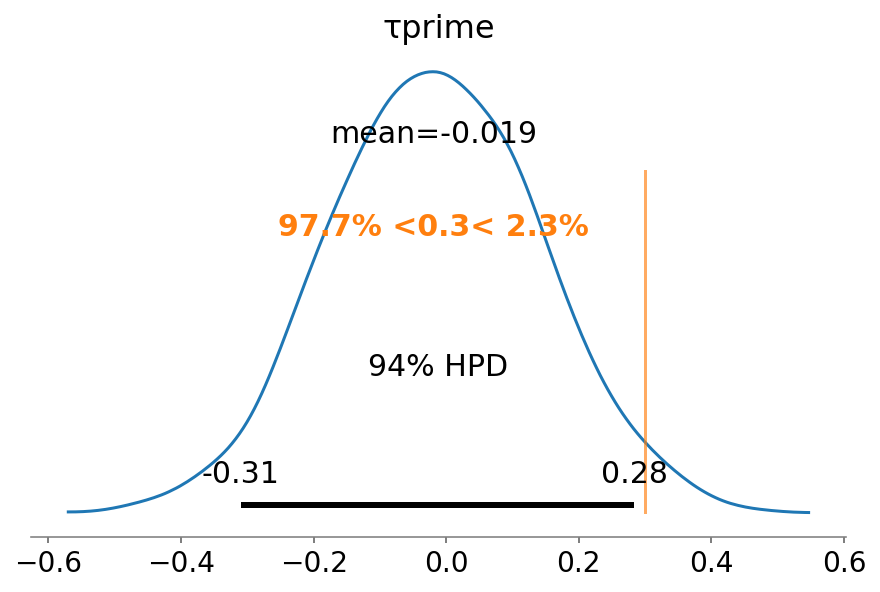

In [16]:
az.plot_posterior(trace, var_names="τprime", ref_val=τprime)

If so, then we might be interested in the $x \rightarrow m \rightarrow y$ slopes, given by $\alpha$ and $\beta$ respectively

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd4c88d25d0>],
      dtype=object)

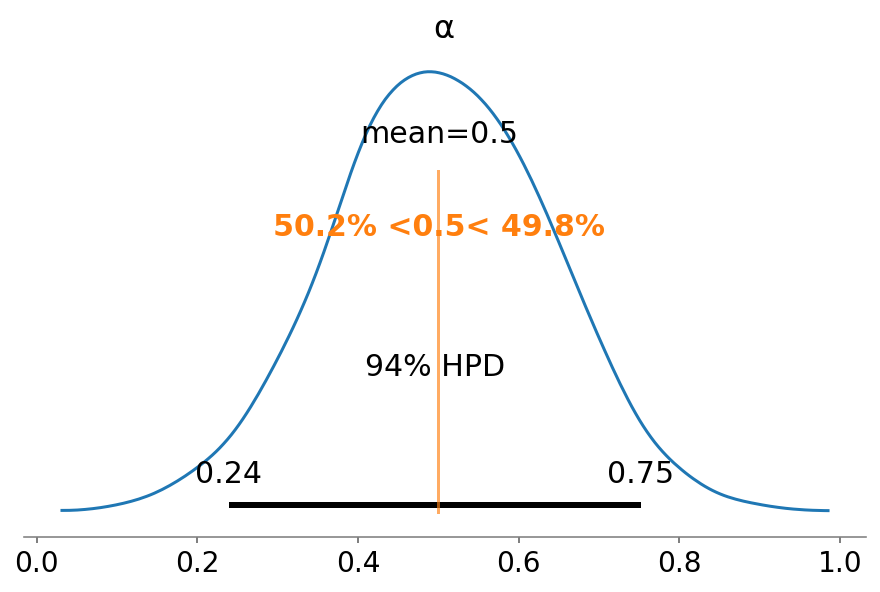

In [17]:
az.plot_posterior(trace, var_names="α", ref_val=α)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd4b8500390>],
      dtype=object)

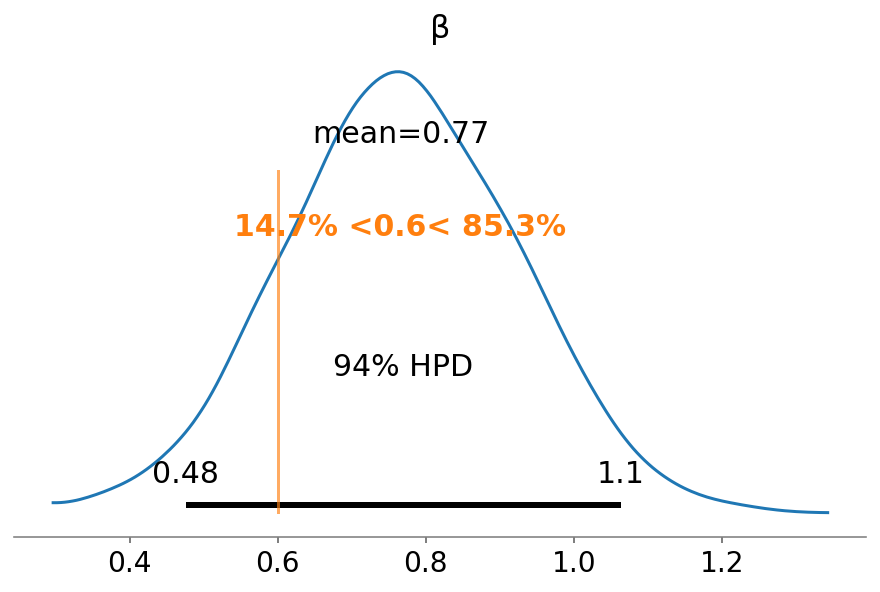

In [18]:
az.plot_posterior(trace, var_names="β", ref_val=β)

## Conclusions

If:

- $\tau' = 0$ and $\theta \neq 0$, then we have evidence that the effect of $x$ upon $y$ is _fully mediated_ by $m$.
- $\tau' \neq 0$ and $\theta \neq 0$, then we have evidence that the effect of $x$ upon $y$ is _partially mediated_ by $m$.

## For completeness, plot the full set of posteriors

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd4fee77790>,
      dtype=object)

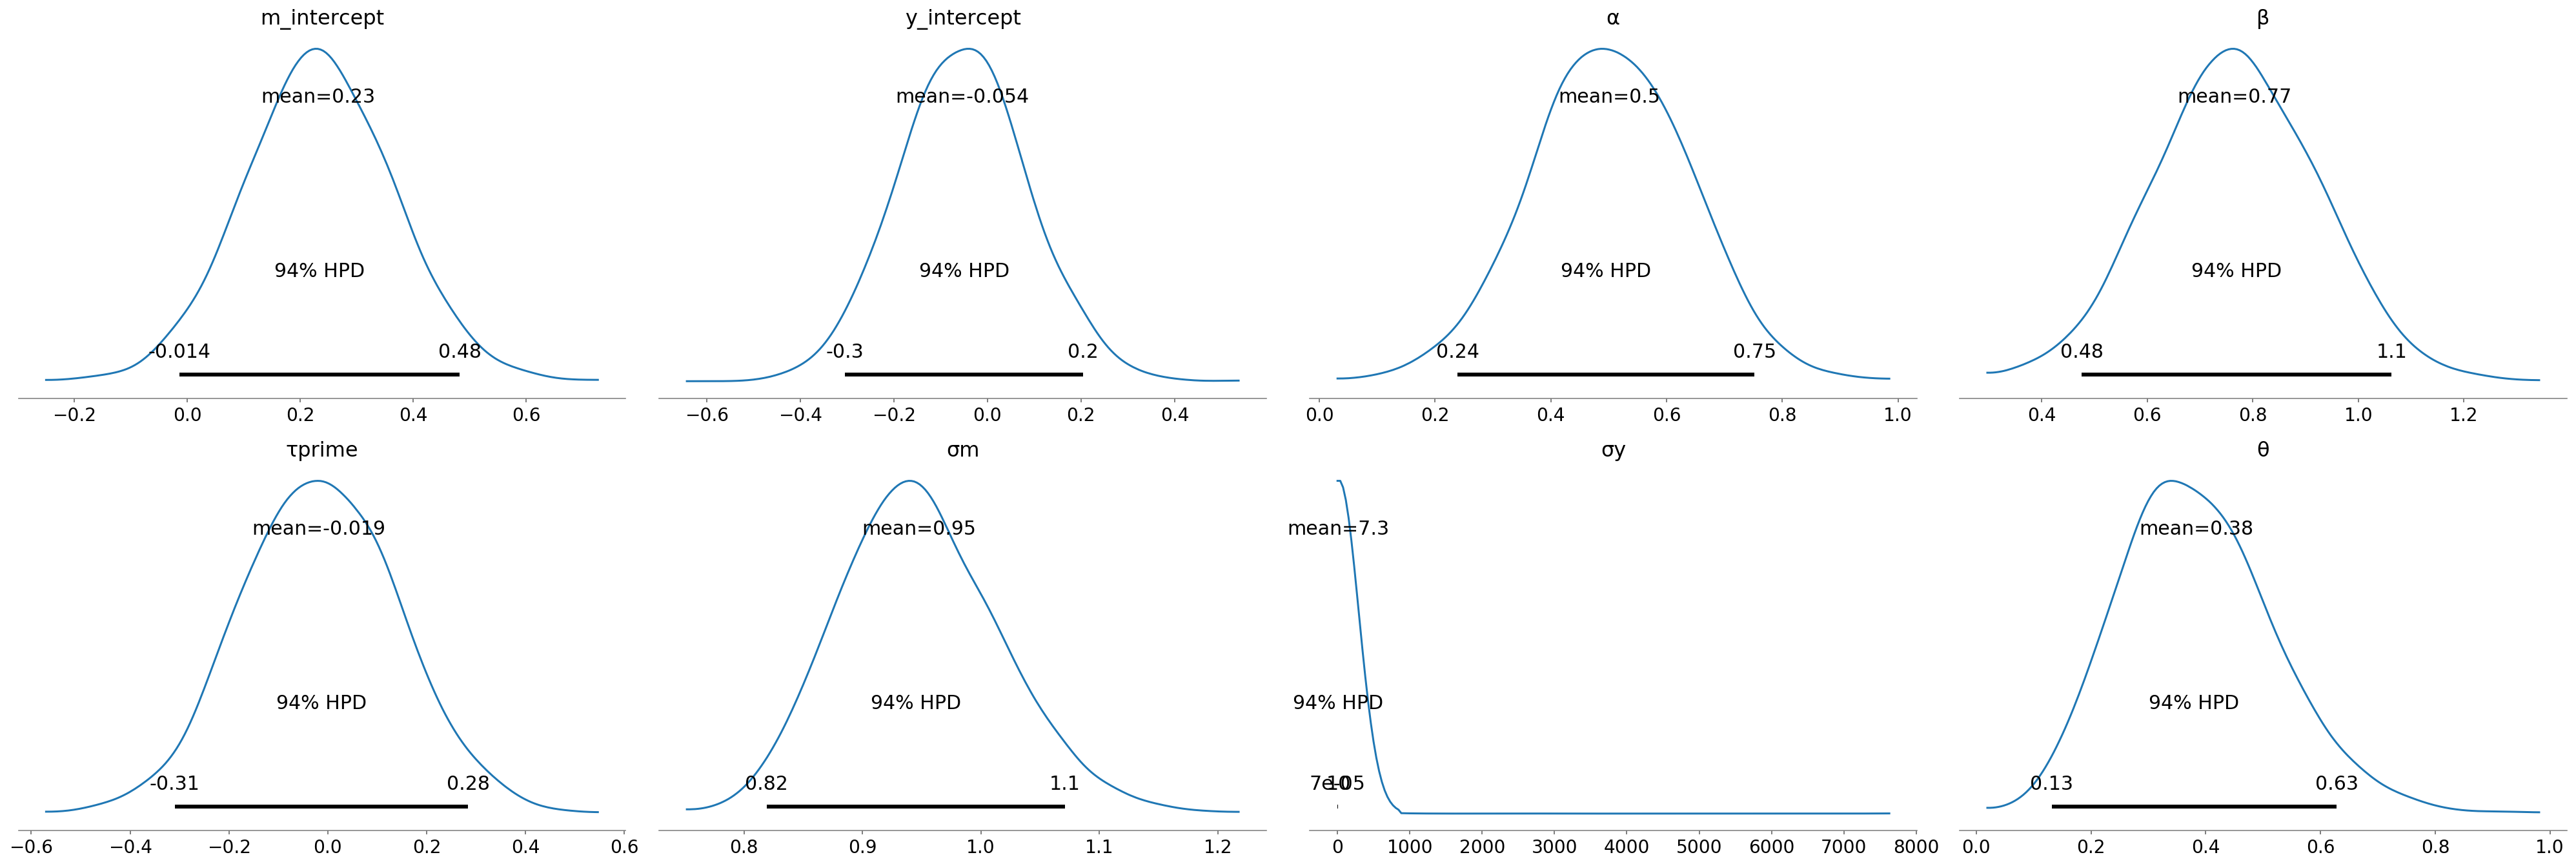

In [19]:
# for completeness, plot the full set of posteriors
az.plot_posterior(trace)

## Posterior predictive checks
As a sanity check, compare the posterior predictions with the observed data.

In [81]:
def posterior_prediction_plot(trace, x, m, y, ax):

    xi = np.linspace(np.min(x), np.max(x), 20)
    mi = np.linspace(np.min(m), np.max(m), 20)
    
    _m_intercept = np.expand_dims(trace["m_intercept"], axis=1)
    _y_intercept = np.expand_dims(trace["y_intercept"], axis=1)
    _α = np.expand_dims(trace["α"], axis=1)
    _β = np.expand_dims(trace["β"], axis=1)
    _τprime = np.expand_dims(trace["τprime"], axis=1)
    
    # X -> M ====================================================
    mi = _m_intercept + _α * xi
    region = np.percentile(mi, [2.5, 50, 97.5], axis=0)
    ax[1].fill_between(xi,
                       region[0, :],
                       region[2, :],
                       alpha=0.2,
                       edgecolor="w",)
    ax[1].plot(xi, region[1, :])
    
    # X -> Y ====================================================
    yi = _y_intercept + _τprime * xi
    region = np.percentile(mi, [2.5, 50, 97.5], axis=0)
    ax[0].fill_between(xi,
                       region[0, :],
                       region[2, :],
                       alpha=0.2)
    ax[0].plot(xi, region[1, :])
    
    # M -> Y ====================================================
    yi = _y_intercept + _β * mi
    region = np.percentile(mi, [2.5, 50, 97.5], axis=0)
    ax[2].fill_between(xi,
                       region[0, :],
                       region[2, :],
                       alpha=0.2)
    ax[2].plot(xi, region[1, :])

    return ax

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd478d805d0>,
      dtype=object)

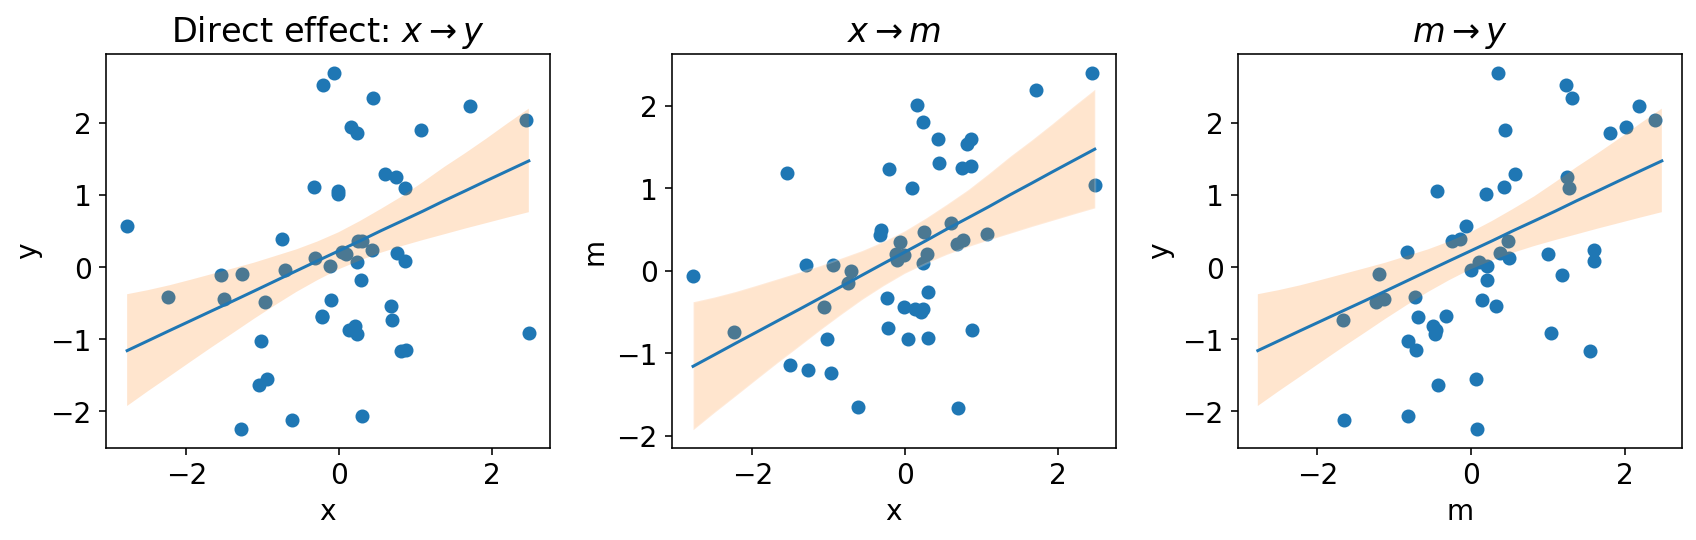

In [82]:
ax = plot_data(x, m, y)
posterior_prediction_plot(trace, x, m, y, ax=ax)

**WARNING:** I am not 100% sure these posterior predictive checks are done correctly.

# References

Yuan, Y., & MacKinnon, D. P. (2009). Bayesian mediation analysis. Psychological Methods, 14(4), 301–322. http://doi.org/10.1037/a0016972

Nuijten, M. B., Wetzels, R., Matzke, D., Dolan, C. V., & Wagenmakers, E.-J. (2014). A default Bayesian hypothesis test for mediation. Behavior Research Methods, 47(1), 85–97. http://doi.org/10.3758/s13428-014-0470-2